<h2> Compute cost while optimized PV gets sparsified

In [1]:
import os
os.chdir('../')

In [1]:
from utils import *
from loader import *

logging.disable(logging.CRITICAL)

from PCAfold import compute_normalized_variance, cost_function_normalized_variance_derivative, KReg
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.ticker as ticker

2025-12-16 10:35:28.812616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-16 10:35:28.812664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-16 10:35:28.813834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def compute_avg(costs):
    n = len(costs)
    sum = np.sum(costs**2)
    return 1/n*np.sqrt(sum)

In [ ]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

dataset_type = "autoignition"

path_data = "data-files/"
path_state = path_data + f"Xu-state-space-{dataset_type}.csv"
filename_metadata = filename_model + "_metadata.pkl"
filename_species_names = "Xu-state-space-names.csv"
path_metadata = "metadata/"

penalty_function = 'log-sigma-over-peak'
start_bw = -6
end_bw = 2
nbr_points_bw = 100
bandwidth_values = np.logspace(start_bw, end_bw, nbr_points_bw)
power = 4
vertical_shift = 1

my_seed = 7
neighbours = [5, 10, 15, 20, 25]

loader = loadData(filename_species_names, path_metadata, filename_metadata)
output_idx = [1, 2, 3, 5, 10, 15, 16, 18, 19]
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
input_scaling = loader.metadata["input scaling"]
input_species_scaling = loader.metadata["input species scaling"]
input_species_bias = loader.metadata["input species bias"]
range_mf  = loader.metadata["range_mf"]
depvar_names_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH'] #loader.metadata["list species output"]
depvar_names_idx = loader.metadata["output idx Kreg"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["output elements"]
if(loader.metadata["dataset_type"].startswith("autoignition_augm")):
        if(loader.metadata["Temperature at output"]):
            depvar_names_idx.append("T")
        for i in range(1,1+loader.metadata["PV dim"]):
            depvar_names_idx.append(f"PV{i}")
PV_dim = loader.metadata["PV dim"]
depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
model = loader.loadModel()
id = loader.metadata["Training_id"]
nbr_input_species = loader.metadata["nbr input species"]

species = Species(path_data)
list_all_species = species.get_list_species()
list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]
print(list_input_species)

['H2NN', 'H2O2', 'H2O', 'H2', 'HNO', 'HO2', 'HONO2', 'HONO', 'H', 'N2O', 'NH2', 'NH', 'NNH', 'NO2', 'NO', 'N', 'O2', 'OH', 'O']


Check that none of the encoder weights is zero

Compute the manifold cost and kernel regression accuracy for every threshold

In [ ]:
cost_array = []
costPV_array = []
MSE_kr_array = []
MSEPV_kr_array = []

costsQoIs_array = []

order_species_removed = []
model = loader.loadModel()

nbr_observations = 100
sample_dataset = False

for i in range(nbr_input_species): #nbr_input_species):

    #Update the model with the threshold
    final_weights = model.get_total_encoder_weights(npy = True)
    
    #get index spcies removed
    my_species = Species(path_data)
    
    list_species = my_species.get_list_species()
    for index in sorted(idx_species_removed, reverse=True):
        list_species.pop(index)

    #get mass fractions of species
    state_space = read_csv(path_state) #header None for low dataset
    state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
    state_space_matrix = state_space.to_numpy()

    wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
    max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species

    #selection of values greater than zero
    #CHECK that none of the weights in the PV is already zero!
    mask = max_wi_Yi > 0

    #Find the index with the minimum max wi Yi which is not zero
    index_species_min_max_wi_Yi = np.argmin(max_wi_Yi[mask])

    #Get the index back in the original array
    index_species_min_max_wi_Yi = np.where(mask)[0][index_species_min_max_wi_Yi]
    
    if(i>0): #do not simplify for the first iteration to have the first value with all input species
        with torch.no_grad():
            model.encoder_species.weight[0,index_species_min_max_wi_Yi] = 0
            order_species_removed.append(list_input_species[index_species_min_max_wi_Yi])


    ##########################
    #Compute the manifold cost
    ##########################
    
    #get the input (PV and f) and the output (interested Yi, T and source terms) data
    input, output = get_dataset(path_data + f"Xu-state-space-{dataset_type}.csv", path_data + f"Xu-state-space_source-{dataset_type}.csv",
                                path_data + f"Xu-T-{dataset_type}.csv", path_data + f"Xu-mf-{dataset_type}.csv", output_idx, idx_species_removed, input_scaling, input_species_scaling, input_species_bias, range_mf)
    
    if(sample_dataset):
        #sample to speed up the tests
        torch.manual_seed(my_seed)
        indices = torch.randint(0, input.size(0), (nbr_observations,)) #set here the number of observations sampled, previous version was with 10k observations (?)
        input = input[indices, :]
        output = output[indices, :]
    

    PV = model.get_PV(input)
    PV_f = torch.cat((PV, input[:, -1].reshape(-1, 1)), dim = 1) #reshape to be (5200,1) instead of (52000)
    output = model.get_source_PV(output, input_species_scaling)

    #scale every column of the PV_f tensor between 0 and 1
    min_vals = PV_f.min(dim=0, keepdim=True).values
    max_vals = PV_f.max(dim=0, keepdim=True).values
    PV_f_scaled = (PV_f - min_vals) / (max_vals - min_vals)

    indepVars = PV_f_scaled.detach().numpy()
    depVars = output.detach().numpy()
    
    #Compute the cost
    variance_data = compute_normalized_variance(indepVars,
                                                depVars,
                                                depvar_names=depvar_names,
                                                bandwidth_values=bandwidth_values)
    costs = cost_function_normalized_variance_derivative(variance_data,
                                                        penalty_function=penalty_function,
                                                        power=power,
                                                        vertical_shift=vertical_shift,
                                                        norm=None)
    print(costs)
    print(f"{np.round(compute_avg(np.array(costs)),3)}")
    cost_array.append(compute_avg(np.array(costs)))
    costPV_array.append(costs[-1])

    costsQoIs_array.append(costs)


    #####################
    #Compute the Kreg MSE
    #####################

    mse_values_model = np.zeros(len(neighbours))
    mse_values_PV = np.zeros(len(neighbours))

    min_output = output.min(dim=0, keepdim=True)[0]  # Minimum values for each column
    max_output = output.max(dim=0, keepdim=True)[0]  # Maximum values for each column

    output_scaled = (output - min_output) / (max_output - min_output)

    #create training and validation datasets
    np.random.seed(my_seed)
    nbr_observations = PV_f_scaled.shape[0]
    indices = np.arange(nbr_observations)
    nbr_train = int(nbr_observations*0.8)
    # Sample 40,000 unique indices
    sampled_indices = np.random.choice(indices, size=nbr_train, replace=False)
    validation_indices = np.setdiff1d(indices, sampled_indices)

    input_model = PV_f_scaled.detach().numpy()
    output_model = output_scaled.detach().numpy()

    for j, neighbour in enumerate(neighbours):

        query = input_model[validation_indices,:]

        kernel_model = KReg(input_model[sampled_indices, :], output_model[sampled_indices, :])
        predicted_model = kernel_model.predict(query, 'nearest_neighbors_isotropic', n_neighbors=neighbour)

        squared_error_model = (predicted_model - output_model[validation_indices,:]) ** 2
        squared_error_PV = (predicted_model[:,-1] - output_model[validation_indices,-1]) ** 2
        mse_model = np.mean(squared_error_model)
        mse_PV = np.mean(squared_error_PV)
        mse_values_model[j] = mse_model
        mse_values_PV[j] = mse_PV

    avg_mse = np.mean(mse_values_model)
    std_mse = np.std(mse_values_model)

    avg_mse_PV = np.mean(mse_values_PV)
    std_mse_PV = np.std(mse_values_PV)

    print(f"{round(avg_mse*10000,3)} (\u00B1 {round(std_mse*10000, 3)})")

    MSE_kr_array.append(avg_mse)
    MSEPV_kr_array.append(avg_mse_PV)

#add the last species into the list of removed species
tensor = model.encoder_species.weight[0, :]
non_zero_indices = torch.nonzero(tensor, as_tuple=True)
print(f"non zero indices in tuple {non_zero_indices}")
non_zero_indices_list = non_zero_indices[0].tolist()
print(f"last element to add {non_zero_indices_list}")
order_species_removed.append(list_input_species[non_zero_indices_list[0]])

[1.9198553756575334, 1.0043309771176352, 0.9790200564075594, 0.8907373267516802, 1.2339381040000656, 0.9549698617816327, 1.0799587845696144, 1.0162042555001025, 1.1146145762031812, 1.0247840830415458, 1.338131286330439]
0.354
0.03 (± 0.024)
[1.9198553756575334, 1.0043309771176352, 0.9790200564075594, 0.8907373267516802, 1.2339381040000656, 0.9549698617816327, 1.0799587845696144, 1.0162042555001025, 1.1146145762031812, 1.0247840830415458, 1.338131286330439]
0.354
0.03 (± 0.024)
[1.9198553756575334, 1.0043309771176352, 0.9790200564075594, 0.8907373267516802, 1.2339381040000656, 0.9549698617816327, 1.0799587845696144, 1.0162042555001025, 1.1146145762031812, 1.0247840830415458, 1.338131286330439]
0.354
0.03 (± 0.024)
[1.919855375657543, 1.004330977117647, 0.9790200564075556, 0.890737326751664, 1.2339381040001576, 0.9549698617816107, 1.0799587845696024, 1.0162042555001185, 1.1146145762032598, 1.0247840830415806, 1.3381312863519936]
0.354
0.03 (± 0.024)
[1.9198553756574328, 1.004330977117683

Plot kernel regression MSE and manifold cost

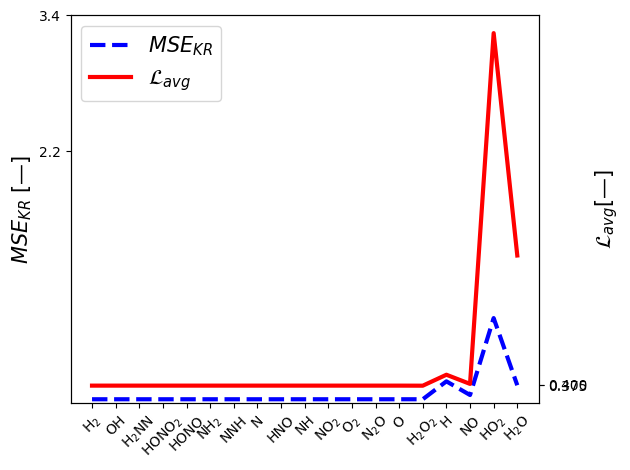

In [ ]:
x_axis_species = np.arange(nbr_input_species, 0, -1)

save = False
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Simplification of the PV/"
name = "curves MSE kr - manifold cost threshold PV v3.png"

latex_species_list = [s.replace('2', r'$_2$') for s in order_species_removed]
latex_species_list = [s.replace('3', r'$_3$') for s in latex_species_list]

fig, ax1 = plt.subplots()

ax1.plot(x_axis_species, MSE_kr_array, 'b--', label="$MSE_{KR}$", linewidth=3)
ax1.set_ylabel('$MSE_{KR}$ [\u2014]', fontsize=15)
ax1.tick_params(axis='y')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{np.round(x*1e3,1)}'))
#ax1.set_xlabel("Nbr. of species in PV", fontsize=15)
ax1.set_yticks([0.0022, 0.0034])
ax1.set_xticks(range(1, len(latex_species_list) + 1))
ax1.set_xticklabels(latex_species_list[::-1], rotation=45)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(x_axis_species, cost_array, 'r-', label=r'$\mathcal{L}_{avg}$', linewidth=3)
ax2.set_ylabel(r'$\mathcal{L}_{avg}$' + '[\u2014]', fontsize=15)
ax2.tick_params(axis='y')
ax2.set_yticks([0.375, 0.400])

# Invert x-axis and set x-axis labels
plt.gca().invert_xaxis()

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize = 15)

#plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300)
plt.show()

In [6]:
name_MSE_list_to_save = f"MSE_list_{id}_low_PV_simplification_{dataset_type}.npy"
name_cost_list_to_save = f"cost_list_{id}_low_PV_simplification_pow4_{dataset_type}.npy"

np.save(name_MSE_list_to_save, MSE_kr_array)
np.save(name_cost_list_to_save, cost_array)

In [7]:
name_costPV_list_to_save = f"costPV_list_{id}_low_PV_simplification_pow4_{dataset_type}.npy"
np.save(name_costPV_list_to_save, costPV_array)

In [8]:
name_MSEPV_list_to_save = f"MSEPV_list_{id}_low_PV_simplification_{dataset_type}.npy"
np.save(name_MSEPV_list_to_save, MSEPV_kr_array)

In [ ]:
name_MSE_QoIs_list_to_save = f"MSE_QoIs_list_{id}_low_PV_simplification_{dataset_type}.npy"
np.save(name_MSE_QoIs_list_to_save, costsQoIs_array)